# Detecting bias in voice recognition

## Background

---

For this project, we are expected to take voice samples from people of various demographics, and process their voices into DeepSpeech that will predict what is being said to see the effects of voice recognition bias. DeepSpeech is a speech-to-text engine that allows predictions of an audio sample transcription to be made in real-time as the file is running [1]. The purpose of this is to predict what is being said in the audio files themselves and see if the file's annotation and the prediction match up. However, because of the nature of a particular project being overly biased towards specific demographics by means of relative numbers, the DeepSpeech engine will become biased towards that demographic. So if there is a voice sample from a person who isn't the main demographic of voice samples, the character error rate of that person's voice sample will be higher than the main demographic's.

The DeepSpeech project can have a wide variety of applications that can be put to use, such as the auto-closed captioning system used for YouTube [3], and potentially for hearing assistence speech-to-text for deaf people. Using DeepSpeech in comparison to other voice recognition engines since it is simpler compared to other engines such as Wav2Vec and Whisper, it's prediction results that are somewhere in between the two without having to predict the stutter of the audio sample [2] [3]. This can mean that with relatively little requirements on its part, it can somewhat accurately predict what the speaker has said in the audio sample. However, as with all prediction-based algorithms, there is always some amount of bias being fed into the algorithm, and this is nothing new to prediction-based systems. 

To address this issue, or at least find out what are the general trends and biases that these engines have, a company known as Artie Inc. has developed what they called the Artie Bias Corpus. This dataset, which is shown in [6], takes audio samples from various people of different demographics, such as races, gender, age groups and even accents and compare them against the DeepSpeech algorithm in order to see how biased the results are. For this to happen, people from five main demographics voluntarily participated in this study to record their own audio samples (over 1700 in total) and submit them to Artie Inc. and then measure the various error rates between various combinations of those demographics to see where the bias is most apparent [7]. The prediction for what is being said in the audio is transcribed in the artie-bias-corpus.tsv file within the data directory and then predictions are made with three different engines (Google, DeepSpeech, and Amazon) with various accents implemented and then the predictions are made within their respective .tsv files, with various levels of bias and success [6][7].

Challenges that are faced when traditionally using speech to text services such as Google and Alexa voice services is that they're only tested with overwhelmingly white American accents, hence why there's a whole lot of bias present in voice recognition [4] [5]. In the Artie Bias Corpus report, both of their algorithms were put to the test along with the DeepSpeech algorithm which was, at the start of the report, possibly unbiased initially. As more annotations and voice samples are fed into the system, the algorithm is more influenced by the samples, and in most cases, they seem to be male American accents in the Artie Bias Corpus voice samples linked in the repository of [6]. By comparing the predictions of the Google and Amazon voice engines in comparison to the DeepSpeech engine, Indian accents get funkier results from the same voice sample in comparison to British and American accents, which seem to be pretty similar and produce less error. All three engines have a bias towards American male accents, although the DeepSpeech engine seems to produce no noticeable gender bias in comparison to Google's engine in the figure below [4] [6] [7, Fig. 4].

---

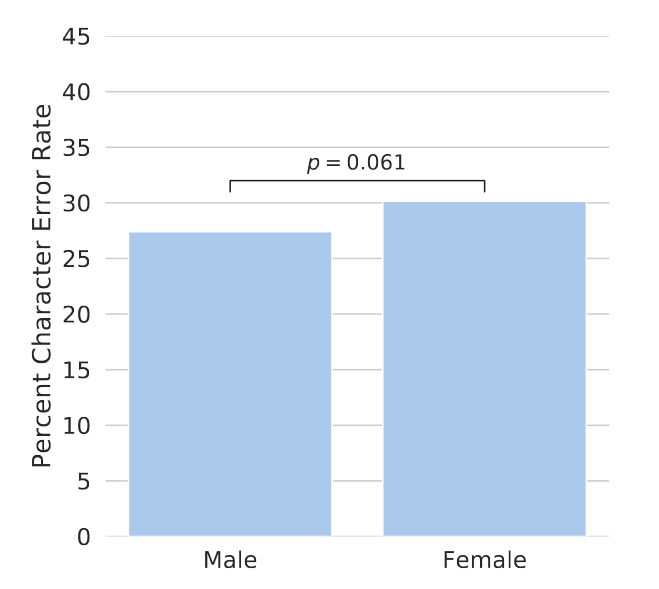

Image is Figure 4 from [7]

---

In comparison to the pre-existing work over on GitHub found on [6], we are including new voice samples found from Professor Lectures on YouTube and then seeing what the predictions made from DeepSpeech turn out to be. We would have to create a spreadsheet document and would eventually turn that into a .tsv file, as we would compare the actual sentence in comparison to DeepSpeech's prediction. To do this, we would have to collect audio samples from these YouTube videos, and the methodology to what kind of information we have collected here goes as follows for accents: 2 American, 2 Scottish, 2 British, 2 Australian, and 2 Indian. Gender wouldn't matter too much as the figure above shows that the bias isn't as pronounced as it was with Google and Amazon's engine. By contrast, the bias this system had towards American English accents in comparison to Indian English accents can very much not be ignored [7, Fig. 5]. We must then see the outputs of the predictions to see how close they were to the actual sentence being said in the first couple of seconds in the video to determine the gender and racial bias and confirm or reject our claim.

---

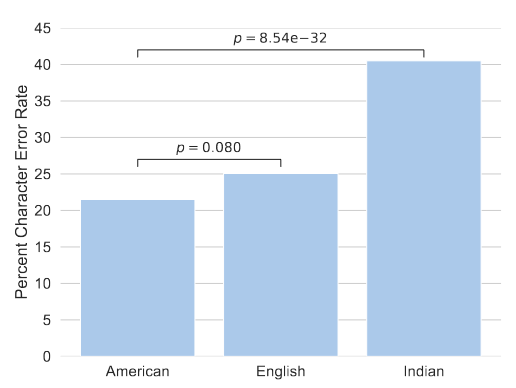

Image is Figure 5 from [7]

## Working with the existing code

---
To begin with, we have to adapt the code from the GitHub repository of the Artie Bias Corpus, which is shown here in [6].

Summary of the code:
The Artie Bias Corpus measures the bias of a speech model by comparing annotations made by the Artie Bias Corpus contributors,which are treated as the ground truth, to the annotations made by the speech model. The bias is defined as the Levenshtein distance between the Artie annotations and the model's annotations divided by the number of words present in the Artie annotations. The Levenshtein distance measures the similarity between two strings; in this codebase the Levenstein distance is computed by comparing two words, and increasing the distance by 1 whenever words in the same position do not match.

The script starts by calling the detect_bias Function. This function takes the artie annotations, annotations made by one to two speech models, and one to two demographics present in the Artie annotation's demographics. It calls print_args_error() if any of the above parameters are missing, and then calls check_args to check the parameters for invalid values. The number of models and demographics in the parameters are then checked, depeneding on if two models and one demographic or if one model or two demographics were input, the script utilizes two different functions, compare_two_models(), and detect_bias_in_one_model respectively.
 
Before compare_two_models() or detect_bias_in_one_model() is called in either scenario, get_merged_df() is called to check the Artie and speech model annotation files for the correct structure. After verifying the structure of both files, the annotations present on both files are inserted on to a new merged dataframe. The Levenhstein distance and error rate between the annotations are then calculated and inserted into the dataframe.

compare_two_models() prints the error rate for both models on the single demographic; detect_bias_in_one_model does something similar where the error rate is printed for two demographics on the same model.

When adapting the code to colab, the main method present in the original detect_bias.py file was changed to the detect_bias for convenience. Because of this, we made several variables in the main method global. For our claim validation since we are using our own samples, we will be inputting our own hand annotations rather than the Artie annotatons for the first parameter in detect_bias.

In [1]:

!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/14aFeXQiSKKgQEg3r48fhd0VdKjxnDnrn?usp=share_link", quiet=True)

['/content/tsv_files/deepSpeech.tsv', '/content/tsv_files/ourAnnot.tsv']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from __future__ import absolute_import, division, print_function

import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.special as special
from scipy import stats
import os

In [5]:
def levenshtein(a,b):
    '''
    The following code is from: http://hetland.org/coding/python/levenshtein.py
    This is a straightforward implementation of a well-known algorithm, and thus
    probably shouldn't be covered by copyright to begin with. But in case it is,
    the author (Magnus Lie Hetland) has, to the extent possible under law,
    dedicated all copyright and related and neighboring rights to this software
    to the public domain worldwide, by distributing it under the CC0 license,
    version 1.0. This software is distributed without any warranty. For more
    information, see <http://creativecommons.org/publicdomain/zero/1.0>
    
    Calculates the Levenshtein distance between a and b.
    '''
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a, b = b, a
        n, m = m, n

    current = list(range(n+1))
    for i in range(1, m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1, n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)

    return current[n]

In [6]:
def get_error_rate(item, unit):
    '''
    The WER is defined as the edit/Levenshtein distance on word level divided by
    the amount of words in the original text.
    In case of the original having more words (N) than the result and both
    being totally different (all N words resulting in 1 edit operation each),
    the WER will always be 1 (N / N = 1).
    '''
    error_rate = (item[unit+'_dist'] / item[unit+'_len'])
    return error_rate

In [7]:
def get_levenshtein_distance(item, unit):
    '''
    unit is either char or word
    '''
    # lowercase both ground-truth and prediction and remove punctuation
    # for calculation of edit distance
    ground_truth = item['sentence'].lower().translate(str.maketrans('', '', string.punctuation))
    prediction = item['prediction'].lower().translate(str.maketrans('', '', string.punctuation))
    distance = 0;
    if unit == 'word':
        distance = levenshtein(ground_truth.split(), prediction.split())
    elif unit == 'char':
        distance = levenshtein(ground_truth, prediction)
    else:
        print('ERROR: must be word or char')

    return distance

In [8]:
def get_merged_df(artie_bias_file, prediction_file):
    # Import the ground-truth transcripts and demographic tags
    ground_truth_df = pd.read_csv(artie_bias_file, delimiter='\t')
    if not ground_truth_df.columns.tolist() == ['client_id', 'path', 'sentence',
                                                'up_votes', 'down_votes', 'age',
                                                'gender', 'accent']:
        print("\n### ERROR: Your ARTIE_CORPUS TSV file does not have the correct column structure.\n")
        exit(1)
    else:
        ground_truth_df['path'] = ground_truth_df['path'].apply(lambda path: os.path.splitext(path)[0])

    prediction_df = pd.read_csv(prediction_file, delimiter='\t')
    if not prediction_df.columns.tolist() == ['path','prediction']:
        print("\n### ERROR: Your PREDICTIONS TSV file does not have the correct column structure.\n")
        exit(1)
    else:
        prediction_df['path'] = prediction_df['path'].apply(lambda path: os.path.splitext(path)[0])
        prediction_df['prediction'].fillna("", inplace=True)
    
    # Merge ground-truth (which has demographic data) and predictions
    pred_df = pd.merge(left=ground_truth_df,
                  right=prediction_df,
                  left_on='path',
                  right_on='path')
    # calculate utterance-level statistics
    if unit == 'word':
        pred_df[unit+'_len'] = pred_df['sentence'].str.split().str.len()
    elif unit == 'char':
        pred_df[unit+'_len'] = pred_df['sentence'].str.len()
    pred_df[unit+'_dist'] = pred_df.apply(get_levenshtein_distance, axis=1, unit=unit)
    pred_df[unit+'_error_rate'] = pred_df.apply(get_error_rate, axis=1, unit=unit)

    return pred_df


In [9]:
def get_demographic_class(demographic):
    if demographic in ['male','female']:
        return "gender"
        
    elif demographic in ['african','australia','bermuda','canada','england',
                         'hongkong','indian','ireland','malaysia','newzealand',
                         'philippines','scotland','singapore','southatlandtic',
                         'us','wales']:
        return "accent"
        
    elif demographic in ['teens','twenties','thirties', 'fourties', 'fifties',
                         'sixties', 'seventies', 'eighties', 'nineties']:
        return "age"
        
    else:
        print("ERROR: your requested demographic:", demographic, " is not a default, please check spelling or add it to this script.")
        print("Here is the list of demographics in the Artie Bias Corpus:",
              ['male','female','african','australia','bermuda','canada',
               'england','hongkong','indian','ireland','malaysia','newzealand',
               'philippines','scotland','singapore','southatlandtic',
               'us','wales','teens','twenties','thirties', 'fourties', 'fifties',
               'sixties', 'seventies', 'eighties', 'nineties'])
        exit(1)

In [10]:
def compare_two_models(unit, demographic, pred_dfs):
    '''
    run the main program
    '''

    demographic_class = get_demographic_class(demographic)
        
    groups=[]
    for i,df in enumerate(pred_dfs):
        errors=df[df[demographic_class] == demographic][unit+'_error_rate']
        groups.append(errors)
        print("\n###", demographic, unit, "error rate on" ,"for model", i, "=", np.mean(errors),
              "( for", len(errors), "audio clips )")
        
    print("\n###", "one-way ANOVA result:", stats.f_oneway(groups[0], groups[1]))

In [11]:
def detect_bias_in_one_model(unit, demographics, pred_df):
    '''
    run the main program
    '''

    groups=[]
    for demographic in demographics:
        demographic_class = get_demographic_class(demographic)
        errors=pred_df[pred_df[demographic_class] == demographic][unit+'_error_rate']
        groups.append(errors)
        print("\n###", demographic, unit, "error rate =", np.mean(errors),
              "( for", len(errors), "audio clips )")

    print("\n###", "one-way ANOVA result:", stats.f_oneway(groups[0], groups[1]))

In [12]:
def plot_demographic_error(df, unit, demographic, user_file):  
    '''
    create a bar plot along a certain demographic, according to
    either CER or WER
    run the main program
    '''

    demographic_class = get_demographic_class(demographic)
    
    demo_df = df.groupby([demographic_class])[[unit+'_dist', unit+'_len']].sum()
    demo_df[unit+'_error_rate'] = demo_df.apply(get_error_rate, axis=1, unit=unit)
    ax = demo_df.sort_values(unit+'_error_rate').plot.bar(y=unit+'_error_rate', rot=0)
    plt.title('Effect of *' + demographic_class.upper() + '* on '
              + unit.upper() + ' Error Rate in ' + user_file.upper())
    plt.ylabel('Average Percentage (%) ' + unit +'_error_rate' + ' for Population')
    plt.xlabel(demographic_class + ' of Talker')
    plt.show()

In [13]:
def print_args_error(error):
    print("\n","ERROR: `detect_bias.py` requires **three** positional arguments, at least one of them is", error) 

    print(
        '''
        Usage: detect_bias.py ARTIE_CORPUS PREDICTIONS DEMOGRAPHIC
        
        ARTIE_CORPUS: string: the path to the artie-bias-corpus.tsv file provided in this repo under data/.
        PREDICTIONS:  string: prediction TSV(s) for the models you wish to compare. If more than one, then comma-separated
        DEMOGRAPHIC:  string: the demographic(s) used for comparison.  If more than one, then comma-separated
                              ['male', 'female', 'indian', 'england', 'twenties', 
                               'thirties', etc. - consult the README for a full list]
        e.g.:  $ ./detect_bias.py "artie-bias-corpus.tsv" "your-model-predictions.tsv" "male,female"
        '''
        #UNIT:         string: 'word' for Word Error Rate comparison, and 'char' for Character Error Rate comparison.
    )

In [14]:
def check_args(user_files,artie_data,unit,demographics):
    '''
    a function to check all the input arguments and throw errors if needed
    '''
    if len(user_files)>2:
        print('''
        ERROR: You are trying to compare more than two models. 
               This is not currently supported. You should make changes
               to the main() function call to suit your needs.
              ''')
        exit(1)
    bool_exist=[os.path.isfile(i) for i in user_files]
    bool_exist.append(os.path.isfile(artie_data))
    if sum(bool_exist)<(len(user_files)+1):
        print("Provided Args: ", artie_data, unit, user_files, demographics)
        print_args_error("invalid")
        exit(1)
    if not (unit in ["char","word"]):
        print('ERROR: unit must be either "char" or "word", not', unit)
        exit(1)
    return True


In [15]:
artie_data = None
user_files = None
demographics = None
unit = ""
def detect_bias(artie_annotation,yhat,demos,vizualize):
    import os
    global artie_data
    global user_files
    global demographics
    global unit
    try:
        artie_data = artie_annotation
        user_files = [ i.strip() for i in str(yhat).split(",") ]
        demographics = [ i.strip() for i in str(demos).split(",") ]
        unit = "word" # TODO make this an optional CL arg
    except IndexError:
        print_args_error("missing")
        exit(1)

    check_args(user_files,artie_data,unit,demographics)  
    ## COMPARE TWO DEMOGRAPHICS
    if len(demographics)>1 and len(user_files)==1:
        print("BEGIN BIAS DETECTION in", user_files[0])
        
        pred_df = get_merged_df(artie_data, user_files[0])
        detect_bias_in_one_model(unit, demographics, pred_df)
        pred_dfs=[pred_df]
        
    ### COMPARE TWO MODELS
    elif len(demographics)==1 and len(user_files)>1:
        print("BEGIN MODEL COMPARISON of", user_files)
        
        pred_dfs = [ get_merged_df(artie_data, user_file)
                     for user_file in user_files]
        compare_two_models(unit, demographics[0], pred_dfs)

    else:
        print('''
        ERROR: Currently you can only compare two models 
               along one demographic line, or one model along two demographics.
               If you want to do something else you can make changes to the code.
        ''')
        exit(1)

    if vizualize:
        for i,pred_df in enumerate(pred_dfs):
            
            plot_demographic_error(pred_df,unit,demographics[0],user_files[i])

In [16]:
detect_bias('tsv_files/ourAnnot.tsv','tsv_files/deepSpeech.tsv','indian,us',False)

BEGIN BIAS DETECTION in tsv_files/deepSpeech.tsv

### indian word error rate = 0.7321428571428572 ( for 2 audio clips )

### us word error rate = 0.5347222222222222 ( for 2 audio clips )

### one-way ANOVA result: F_onewayResult(statistic=0.20121130209894675, pvalue=0.6976602018820867)


## Validating a claim

---

As stated earlier in this notebook, we wanted to test a claim that was stated in [7] that proved whether or not the DeepSpeech algorithm was biased based on the accent of the speaker. In most cases, this seems to be male American accents due to the overwhelming presence in the testing of voice recognition engines in the US. The claim that we are choosing to validate is as follows:  

**Claim**: DeepSpeech, an existing large text-to-speech model, is biased on accent of the speaker. You could validate this claim by trying out DeepSpeech on some carefully selected "new" test samples and annotating the results yourself.

In this respect, we are testing information that has been proved in two figures in [7], both of which are in the Background section of this notebook, to see if DeepSpeech is indeed biased towards American accents, seemingly with gender not being a prime factor. This would be an interesting claim to make as the Artie Bias Corpus data has tested around 1700 audio samples voluntarily sampled from people, with annotations of the actual sentences. Various .tsv files are in the repository tested with different voice recognition engines were also included, with success varying from one engine to the next. For this notebook, we primarily used the DeepSpeech algorithm and recorded the predictions in another .tsv file and compared that to the actual sentence said and determined how accurate DeepSpeech is and where the bias lies.

Resources that were used for the claim validation included university lectures found on YouTube, where we had to gather two of each accent that we decided to use (American, British, Scottish, Australian, and Indian). Then we had to get the audio samples from those lectures made in a specific timeframe (usually within the first 30 seconds of a video), and then get the predictions with the algorithm. Then we record the predictions in another .tsv file for comparison. Based on the results that we obtained, we will then determine how biased the system is, and whether one person's accent impairs the ability of voice recoginition tools to properly determine what he or she is saying.

In our case, we decided to test out DeepSpeech's prediction system using the audio samples after conversion, annotation and putting them through the algorithm. In the cell above, we see that the comparison is made between two .tsv files, one with the actual sentences and another with prediction as it is loaded into this notebook. We decided to test it out using 2 samples each from the American and Indian Professors' accents, though all of the audio has been sampled from the first 30 seconds of each lecture. After annotating and predicting the text with DeepSpeech, we compared the error rate to see if they can be reproduced. In our findings in one of those instances, we see that the word error rates for Indian accents is much higher than American ones, meaning that voice recognition engines have a harder time understanding what is being said from those with Indian accents. Next we decided to compare the error rates between male and female speakers to see if the error rates are comparable, as in being around 5% within each other. Below is the cell for comparison of American and British accents, and another with both male and female speakers.

---

In [17]:
detect_bias('tsv_files/ourAnnot.tsv','tsv_files/deepSpeech.tsv','male,female',False)

BEGIN BIAS DETECTION in tsv_files/deepSpeech.tsv

### male word error rate = 0.765951642641449 ( for 7 audio clips )

### female word error rate = 0.6802503052503052 ( for 3 audio clips )

### one-way ANOVA result: F_onewayResult(statistic=0.18853683778459493, pvalue=0.6756101225293828)


---

In the cell above, we see that although we could only compare the male and female audio samples from the .tsv files that we already tested. We see that in comparison to the American and Indian accent speakers where the error rate was a giant gap, the gender bias gap isn't as large, although it still favors female speakers, likely because there's more audio clips collected from them. The error rate is closer than the previous collection, still proving that the gender bias isn't as noticable as the accent of the speaker, but slightly bigger than anticipated. For curiousity's sake, we'll test the error rates in both Scottish and Australian speakers to see how well they would stack up compared to the others.

---

In [18]:
detect_bias('tsv_files/ourAnnot.tsv','tsv_files/deepSpeech.tsv','scotland,australia',False)

BEGIN BIAS DETECTION in tsv_files/deepSpeech.tsv

### scotland word error rate = 0.7559523809523809 ( for 2 audio clips )

### australia word error rate = 0.7926421404682273 ( for 2 audio clips )

### one-way ANOVA result: F_onewayResult(statistic=0.4643564471488748, pvalue=0.5659158010522445)


---

Here we see that the error rates for Scottish and Australian speakers is relatively high compared to other demographics, as the DeepSpeech algorithm in the Artie Bias Corpus likely isn't as well trained on either accent, with the closest comparison being British accented speakers. As it can be seen, the error rates are relatively similar, with little difference between the two for DeepSpeech to understand them. Overall, we can say that although there seems to be little in terms of gender bias, the accent of the speaker does make a difference for the DeepSpeech algorithm to understand the users. Thus we can say that the bias can interfere with voice recognition, proving the claim that was made earlier is true, meaning that DeepSpeech is biased on the accent on the speaker, favoring American accents more than anything else.

---

## References

Note that References 10-19 are used for creating the voices samples we used for annotations and predictions using DeepSpeech for our .tsv files

[1] Mozilla. "Project DeepSpeech." GitHub. https://github.com/mozilla/DeepSpeech (Accessed December 6, 2022)

[2] M. Shkhanukova. "ASR state-of-the-art: Wav2Vec, Whisper, DeepSpeech." Medium. https://medium.com/@milana.shxanukova15/asr-state-of-the-art-wav2vec-whisper-deepspeech-e1b715c2aed0 (Accessed December 6, 2022)

[3] A. Talasila. "Generate Subtitles for any video file using Mozilla DeepSpeech." Towards Data Science. https://towardsdatascience.com/generating-subtitles-automatically-using-mozilla-deepspeech-562c633936a7 (Accessed December 6, 2022)

[4] K. Wiggers. "Artie releases tool to measure bias in speech recognition models." VentureBeat. https://venturebeat.com/ai/artie-releases-tool-to-measure-bias-in-speech-recognition-models/ (Accessed December 6, 2022)

[5] R. Horrigan. "Announcing The Artie Bias Corpus: a speech dataset for bias detection in voice applications." LinkedIn. https://www.linkedin.com/pulse/announcing-artie-bias-corpus-speech-dataset-detection-ryan-horrigan/ (Accessed December 6, 2022)

[6] Artie Inc. "Artie Bias Corpus + Tools." GitHub. https://github.com/artie-inc/artie-bias-corpus (Accessed December 6, 2022)

[7] J. Meyer et al. "Artie Bias Corpus: An Open Dataset for Detecting Demographic Bias in Speech
Applications." Artie, Inc. https://aclanthology.org/2020.lrec-1.796.pdf (Accessed December 6, 2022)

[8] tugstugi. "Speech Recognition with DeepSpeech." Google Colab. https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/MozillaDeepSpeech.ipynb?authuser=2#scrollTo=3KUlO4oiA8CM (Accessed December 7, 2022)

[9] R. LIN. "Convert Video/Audio to Text with Mozilla DeepSpeech." Medium. https://reneelin2019.medium.com/video-audio-to-text-with-mozilla-deepspeech-2f7c3b3aef1f (Accessed December 9, 2022)

[10] University of Oxford. "Oxford London Lecture 2012: "21st Century -- The Last Century of Youth"". YouTube. https://www.youtube.com/watch?v=G3L9XOHqzak (May 13, 2012). (Accessed December 6, 2022)

[11] University of Birmingham. "Professor John Curtice - How has Brexit reshaped British politics? (full lecture)". YouTube. https://www.youtube.com/watch?v=eTwCZ6oifFQ (October 16, 2017). (Accessed December 6, 2022)

[12] YaleCourses. "Lecture 1: Introduction to Power and Politics in Today’s World". YouTube. https://www.youtube.com/watch?v=BDqvzFY72mg (September 17, 2019). (Accessed December 7, 2022)

[13] CosmoLearning. "Harvard ENGL E-129 - Lecture 1: Introduction". YouTube. https://www.youtube.com/watch?v=A0mFFJJLM2M (January 18, 2015). (Accessed December 7, 2022)

[14] UNSW Community. "The Inaugural Patrick O'Farrell Memorial Lecture - Professor David Fitzpatrick: Australia's Irish Qu". YouTube. https://www.youtube.com/watch?v=ExZRHM1Zu_A (December 15, 2011). (Accessed December 7, 2022)

[15] Virginia University of Wellington. "PUBLIC LECTURE: 'How to defend New Zealand' | Professor Hugh White, Australian National University". YouTube. https://www.youtube.com/watch?v=_4B-JZQG9FA (September 12, 2019). (Accessed December 7, 2022)

[16] Centre for Scottish Culture. "History Scotland Lecture 1: Who were the Jacobites and what did they want for Scotland?". YouTube. https://www.youtube.com/watch?v=0_zXZz0Jar8 (May 14, 2018). (Accessed December 7, 2022)

[17] Robert Gordon University. "Professorial Lectures 2019: Professor Rhona Flin". YouTube. https://www.youtube.com/watch?v=UyphlSA6zfE (April 3, 2019). (Accessed December 7, 2022)

[18] Vinay Lal. "Indian Civilization [Lec 01]". YouTube. https://www.youtube.com/watch?v=93JMjX1XECo (September 2, 2013). (Accessed December 7, 2022)

[19] FICCI India. "#FICCIat90 Leadership Lecture Series | Prof Ram Charan". YouTube. https://www.youtube.com/watch?v=VhMdSQrGbY0 (July 27, 2017). (Accessed December 7, 2022)